In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    auc,
)
import faiss
from collections import Counter
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import seaborn as sns  # Import seaborn for advanced plotting

It is necessary to take a sample of the dataset as knn model would take too long to run if we use all 800,000 rows

In [2]:
# Load dataset and clean a little
df = pd.read_csv('../datasets/after_great_recession.csv')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop(['NAICS_U.S._Industry_Title', 'Business_Type'], axis=1)
df = df.sample(n=100000)
df

,Loan_Term,Number_Of_Employees,Urban_Rural_Status,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,SBA_Approved_Amount,Region,Franchise_Status,Month_Of_Approval
421247,84,16,Urban,0,0,182000,1,91000,South,0,August
601432,276,8,Unknown,0,0,1038533,1,749821,West,0,January
650023,300,7,Urban,0,0,452200,1,339150,West,0,October
717,89,3,Unknown,1,0,80000,1,40000,West,0,September
356943,300,5,Urban,0,0,170000,1,127500,West,0,February
...,...,...,...,...,...,...,...,...,...,...,...
189841,126,1,Unknown,0,0,295500,1,221625,South,0,October
498395,48,2,Unknown,0,0,10000,1,8000,Northeast,0,August
668341,60,61,Urban,0,0,75000,1,37500,Northeast,0,January
194400,120,6,Unknown,0,0,65000,1,52000,West,0,October


### creating dummy variables and splitting data to tests and training

We are using **dummy encoding** to transform categorical variables into numerical representations suitable for machine learning models. This process converts categories into binary (0 or 1) columns, allowing algorithms like logistic regression to process the data effectively. Dummy variables help maintain the interpretability of categorical data while ensuring compatibility with numerical modeling techniques.

**Why Certain Columns Are Excluded**
The following columns are excluded from dummy encoding:
- **Loan_Term**, **Number_Of_Employees**, **Disbursement_Gross**: These columns are numerical and do not require encoding.
- **Revolving_Line_Of_Credit**, **Low_Documentation_Loan_Program**, **Franchise_status**: These columns already contain binary values (0 and 1) and do not need further transformation.
- **Loan_Status**: This column is the target variable (dependent variable) for our logistic regression model and should not be transformed.

By excluding these columns, we ensure that the essential structure of the data remains intact while focusing on converting only the necessary categorical features into dummy variables.

In [3]:
categorical_columns = ['Urban_Rural_Status', 'Region', 'Month_Of_Approval']
dummied_df = pd.get_dummies(df, drop_first=True)
dummied_df = dummied_df.astype(int)
dummied_df

,Loan_Term,Number_Of_Employees,Revolving_Line_Of_Credit,Low_Documentation_Loan_Program,Disbursement_Gross,Loan_Status,SBA_Approved_Amount,Franchise_Status,Urban_Rural_Status_Unknown,Urban_Rural_Status_Urban,...,Month_Of_Approval_December,Month_Of_Approval_February,Month_Of_Approval_January,Month_Of_Approval_July,Month_Of_Approval_June,Month_Of_Approval_March,Month_Of_Approval_May,Month_Of_Approval_November,Month_Of_Approval_October,Month_Of_Approval_September
421247,84,16,0,0,182000,1,91000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
601432,276,8,0,0,1038533,1,749821,0,1,0,...,0,0,1,0,0,0,0,0,0,0
650023,300,7,0,0,452200,1,339150,0,0,1,...,0,0,0,0,0,0,0,0,1,0
717,89,3,1,0,80000,1,40000,0,1,0,...,0,0,0,0,0,0,0,0,0,1
356943,300,5,0,0,170000,1,127500,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189841,126,1,0,0,295500,1,221625,0,1,0,...,0,0,0,0,0,0,0,0,1,0
498395,48,2,0,0,10000,1,8000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
668341,60,61,0,0,75000,1,37500,0,0,1,...,0,0,1,0,0,0,0,0,0,0
194400,120,6,0,0,65000,1,52000,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Before fitting the model, we will **Z-score normalize** the following columns:

- **Loan_Term**
- **Number_Of_Employees**
- **Disbursement_Gross**
- **SBA_Approved_Amount**

Z-score normalization ensures these continuous variables are scaled to have a mean of 0 and a standard deviation of 1. This is critical for logistic regression because it:
- Ensures that all features contribute equally to the model, preventing those with larger numerical ranges from dominating the results.
- Improves the numerical stability and convergence of the optimization algorithm used in logistic regression.

Normalization will be applied **after splitting the datasets into training and test sets** to prevent data leakage and ensure that the scaling is based only on the training data.

**Oversampling the Negative Class**

To address the class imbalance, where the negative class (e.g., "CHGOFF") has significantly less data, we will attempt oversampling of the negative class. The goal is to balance the class distribution and improve the model’s ability to identify true negatives, potentially enhancing specificity further.

**Steps:**

- **Technique:** Apply **SMOTE (Synthetic Minority Oversampling Technique)** to create synthetic samples for the minority class in the training set only, keeping the test set unbiased.
- **Re-train:** Train the logistic regression model on the oversampled data.
- **Evaluate:** Assess specificity, accuracy, precision, recall, and F1 score on the original test set.

**Goal:**

Oversampling aims to improve true negative detection, reduce false positives, and better align model performance with the cost-sensitive requirements of this scenario.

In [4]:
#splitting
X = dummied_df.drop('Loan_Status', axis=1)
y = dummied_df['Loan_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#normalizing
columns_to_normalize = ['Loan_Term', 'Number_Of_Employees', 'Disbursement_Gross', 'SBA_Approved_Amount']

scaler = StandardScaler()

# Apply the scaler to the specified columns
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])
X_test[columns_to_normalize] = scaler.fit_transform(X_test[columns_to_normalize])

#oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

These will be the functions we use for the models

In [6]:
# Define evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

def calculate_profit_loss(row):
    if row['Predicted'] == 0:  # Predicted as default
        return 0  # No profit or loss for prediction as default

    elif row['Predicted'] == 1:  # Predicted as paid in full
        if row['Actual'] == 0:  # Actually defaulted
            return -5 * 0.05 * row['Disbursement_Gross']  # Loss due to incorrect prediction
        else:  # Actually paid in full
            return 0.05 * row['Disbursement_Gross']  # Profit due to correct prediction

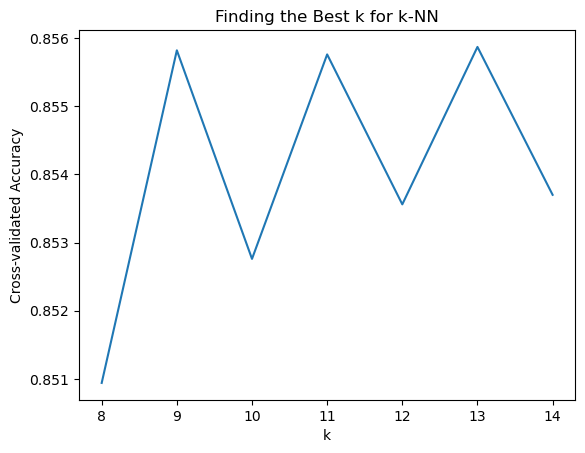

The best k value is: 13


In [8]:
# Range of k values to test
k_range = range(8, 15)

# Cross-validation to find the best k
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Plot the results
plt.plot(k_range, cv_scores)
plt.xlabel('k')
plt.ylabel('Cross-validated Accuracy')
plt.title('Finding the Best k for k-NN')
plt.show()

# The best k value is the one with the highest accuracy
best_k = k_range[np.argmax(cv_scores)]
print(f"The best k value is: {best_k}")

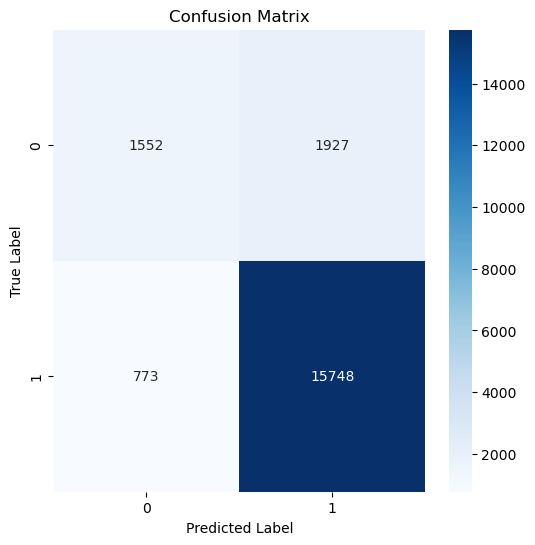

Training Set Accuracy: 0.88
Training Set Precision: 0.90
Training Set Recall: 0.96
Training Set F1 Score: 0.93

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.49      0.58     13772
           1       0.90      0.96      0.93     66228

    accuracy                           0.88     80000
   macro avg       0.81      0.73      0.76     80000
weighted avg       0.87      0.88      0.87     80000

Testing Set Accuracy: 0.86
Testing Set Precision: 0.89
Testing Set Recall: 0.95
Testing Set F1 Score: 0.92

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.45      0.53      3479
           1       0.89      0.95      0.92     16521

    accuracy                           0.86     20000
   macro avg       0.78      0.70      0.73     20000
weighted avg       0.85      0.86      0.85     20000

The model's performance is consistent between the train

In [13]:
knn = KNeighborsClassifier(n_neighbors=13, algorithm='ball_tree')

# Fit the model on the training set
knn.fit(X_train, y_train)

# Evaluate on the training set
y_train_pred = knn.predict(X_train)
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)

# Evaluate on the testing set
y_test_pred = knn.predict(X_test)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)


# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Specificity calculation
tn, fp, fn, tp = cm.ravel()  # Extract confusion matrix values
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print metrics
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}')
print('\nTraining Set Classification Report:')
print(classification_report(y_train, y_train_pred))

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')
print('\nTesting Set Classification Report:')
print(classification_report(y_test, y_test_pred))

# Check for overfitting
if train_accuracy > test_accuracy + 0.1:
    print("Warning: The model might be overfitting. Consider pruning the tree or reducing max_depth.")
else:
    print("The model's performance is consistent between the training and testing sets.")

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

#Merge df_new and results on the index or appropriate column (if there's a common key)
df_combined = df.join(results)

#Assuming you want to apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

#Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

#Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net}")

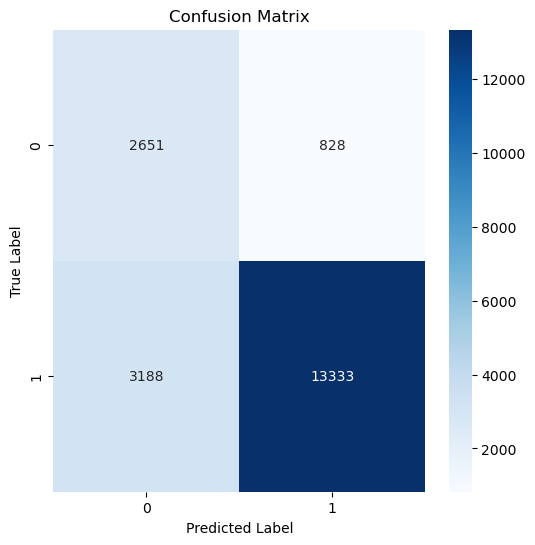

Training Set Accuracy: 0.88
Training Set Precision: 0.91
Training Set Recall: 0.83
Training Set F1 Score: 0.87

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     66228
           1       0.91      0.83      0.87     66228

    accuracy                           0.88    132456
   macro avg       0.88      0.88      0.88    132456
weighted avg       0.88      0.88      0.88    132456

Testing Set Accuracy: 0.80
Testing Set Precision: 0.94
Testing Set Recall: 0.81
Testing Set F1 Score: 0.87

Testing Set Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.76      0.57      3479
           1       0.94      0.81      0.87     16521

    accuracy                           0.80     20000
   macro avg       0.70      0.78      0.72     20000
weighted avg       0.86      0.80      0.82     20000

The model's performance is consistent between the train

In [14]:
# Fit the model on the training set
knn_oversampled = KNeighborsClassifier(n_neighbors=13, algorithm='ball_tree')

knn_oversampled.fit(X_train_resampled, y_train_resampled)

# Evaluate on the training set
y_train_pred = knn_oversampled.predict(X_train_resampled)
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train_resampled, y_train_pred)

# Evaluate on the testing set
y_test_pred = knn_oversampled.predict(X_test)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)


# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=knn_oversampled.classes_, yticklabels=knn_oversampled.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Specificity calculation
tn, fp, fn, tp = cm.ravel()  # Extract confusion matrix values
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print metrics
print(f'Training Set Accuracy: {train_accuracy:.2f}')
print(f'Training Set Precision: {train_precision:.2f}')
print(f'Training Set Recall: {train_recall:.2f}')
print(f'Training Set F1 Score: {train_f1:.2f}')
print('\nTraining Set Classification Report:')
print(classification_report(y_train_resampled, y_train_pred))

print(f'Testing Set Accuracy: {test_accuracy:.2f}')
print(f'Testing Set Precision: {test_precision:.2f}')
print(f'Testing Set Recall: {test_recall:.2f}')
print(f'Testing Set F1 Score: {test_f1:.2f}')
print('\nTesting Set Classification Report:')
print(classification_report(y_test, y_test_pred))

# Check for overfitting
if train_accuracy > test_accuracy + 0.1:
    print("Warning: The model might be overfitting. Consider pruning the tree or reducing max_depth.")
else:
    print("The model's performance is consistent between the training and testing sets.")

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

#Merge df_new and results on the index or appropriate column (if there's a common key)
df_combined = df.join(results)

#Assuming you want to apply the formula to the combined DataFrame
df_combined['Profit_Loss'] = df_combined.apply(calculate_profit_loss, axis=1)

#Calculate the total net profit/loss by summing the 'Profit_Loss' column
total_net = df_combined['Profit_Loss'].sum()

#Print the total net profit/loss
print(f"Total Net Profit/Loss: {total_net}")

average_total_net = total_net / (results.shape[0])

print(f"Average Total Net Profit/Loss: {average_total_net}")

In this **bank loan scenario**, where minimizing false positives is critical due to their 5x higher cost, we have compared two models:
- The **second model** (oversampling) demonstrated higher overall performance in metrics like accuracy, precision, recall, and F1 score.
- However, the **second model** (oversampling) also overfit so we cannot use the model

So therefore the **first model** is better

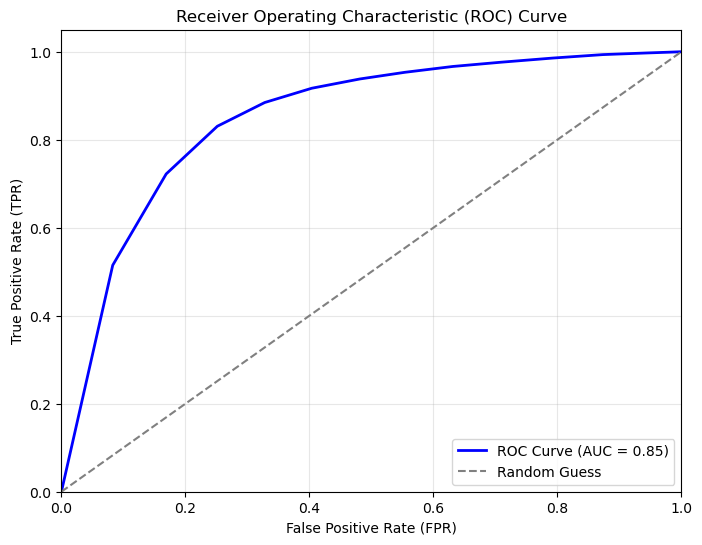

In [15]:
# Calculate probabilities for the positive class
y_test_proba = knn.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

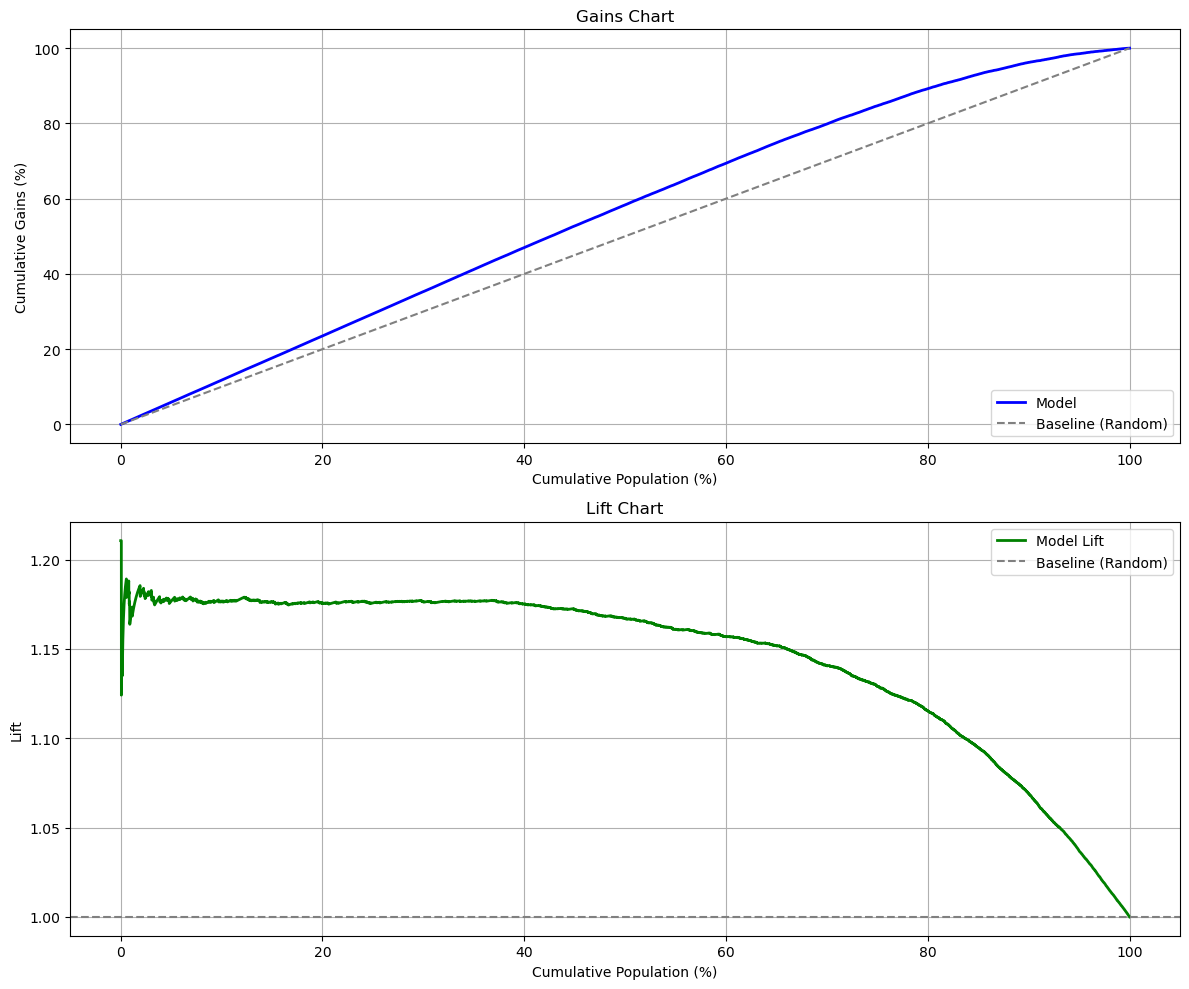

In [12]:
def plot_gains_and_lift_chart(y_true, y_scores):
    """
    Plots a gains chart and lift chart.
    
    Parameters:
        y_true (array-like): True binary labels (0 or 1).
        y_scores (array-like): Predicted probabilities or scores for the positive class.
    """
    # Sort by scores descending and corresponding true labels
    sorted_indices = np.argsort(-y_scores)
    y_true_sorted = np.array(y_true)[sorted_indices]
    
    # Calculate cumulative positives
    cumulative_positives = np.cumsum(y_true_sorted)
    total_positives = np.sum(y_true)
    total_population = len(y_true)
    
    # Gains percentages
    gains = cumulative_positives / total_positives * 100
    population_percentage = np.arange(1, total_population + 1) / total_population * 100
    
    # Lift percentages
    lift = gains / population_percentage
    
    # Plotting
    plt.figure(figsize=(12, 10))
    
    # Gains chart
    plt.subplot(2, 1, 1)
    plt.plot(population_percentage, gains, label='Model', color='blue', lw=2)
    plt.plot([0, 100], [0, 100], '--', color='gray', label='Baseline (Random)')
    plt.xlabel('Cumulative Population (%)')
    plt.ylabel('Cumulative Gains (%)')
    plt.title('Gains Chart')
    plt.legend(loc='lower right')
    plt.grid()
    
    # Lift chart
    plt.subplot(2, 1, 2)
    plt.plot(population_percentage, lift, label='Model Lift', color='green', lw=2)
    plt.axhline(y=1, color='gray', linestyle='--', label='Baseline (Random)')
    plt.xlabel('Cumulative Population (%)')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.tight_layout()
    plt.show()

y_test_pred_probs = knn.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
plot_gains_and_lift_chart(y_test, y_test_pred_probs)

In this analysis, we evaluated two different methods, **oversampling** and **the original**, across several models to determine which data preparation method and model performed best. After comparing the results, we found that **original** outperformed **oversampling** and a higher **k** is needed.

**Key Findings:**
- **original** performed better than **oversampling**, making it the preferred dataframe for further analysis.
- **sampling is necesary** it took around 3 hours to run knn with all 800 thousand rows

**Approaches Tested:**
- **Oversampling:** balanced the dataset using oversampling, however this lead to overfitting
- **Testing K** we realized that a k of 13 was the best value

**Performance Evaluation:**
- **Elapsed Time:**
    - Knn (without sampling): 3 hours
    - Knn (with sampling): 5 minutes
- **ROC Curve:** All models showed similar **AUC = 0.85**.
- **Lift and Gain Charts:** All models displayed comparable results, indicating similar performance in identifying key cases.

**Recommendations for the Bank**
- **When Knn you must sample or a computer with good specs:**
- **Don't oversample:** as it will increase overfitting

- If time is a critical factor, I do not think knn would be a good model to use
 
**Conclusion Summary:**
- **must sample** the dataframe
- **Don't use oversampling as it will overfit**